In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter, HourLocator
from scipy.stats import skew, kurtosis,jarque_bera

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')
# Allow Multiple Output per Cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
# StatsModels for Ordinary Least Squares Regresssion
import statsmodels.api as sm
# Import the adfuller (ADF) Stationarity Test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
# Import QuantStats for Trading Strategy Tear-Sheets
import quantstats as qs

In [2]:
# All data from binance or binance futures || Base currency is USDT

df_btc = pd.read_csv('../data/candle_bns_btc_usdt_1m_202403011651.csv')
df_eth = pd.read_csv('../data/candle_bns_eth_usdt_1m_202403011652.csv')

df_btc_perp = pd.read_csv('../data/candle_bnf_btc_usdt_perpetual_1m_202403011649.csv') 
df_eth_perp = pd.read_csv('../data/candle_bnf_eth_usdt_perpetual_1m_202403011650.csv')

# Sort dataframes by 'timestamp'
df_btc = df_btc.sort_values(by='timestamp')
df_eth = df_eth.sort_values(by='timestamp')
df_btc_perp = df_btc_perp.sort_values(by='timestamp')
df_eth_perp = df_eth_perp.sort_values(by='timestamp')

### Convert to daily data

In [3]:
def convert_to_daily_data(df_btc):
    # Convert 'timestamp' column to datetime
    df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'])

    # Group by date and aggregate the data
    daily_df_btc = df_btc.groupby(df_btc['timestamp'].dt.date).agg({
        'open': 'first',
        'close': 'last',
        'low': 'min',
        'high': 'max',
        'volume': 'sum',
        'cont_records': 'sum',
        'quote_volume': 'sum'
    }).reset_index()

    return daily_df_btc

daily_df_btc = convert_to_daily_data(df_btc)
daily_df_eth = convert_to_daily_data(df_eth)
daily_df_btc_perp = convert_to_daily_data(df_btc_perp)
daily_df_eth_perp = convert_to_daily_data(df_eth_perp)

daily_df_btc["name"] = "BTC_SPOT"
daily_df_eth["name"] = "ETH_SPOT"
daily_df_btc_perp["name"] = "BTC_PERPETUAL"
daily_df_eth_perp["name"] = "ETH_PERPETUAL"

### First moment analysis, normality check + fourth moment analysis

In [4]:
# Calculate mean, skewness, and kurtosis for each dataset
for df in [daily_df_btc, daily_df_eth, daily_df_btc_perp, daily_df_eth_perp]:
    print(f"Dataset: {df.name.unique()}")
    print("Mean:")
    print(df['close'].mean())
    print("\nSkewness:")
    print(df['close'].skew())
    print("\nKurtosis:")
    print(df['close'].kurtosis())
    print("\n")

for df in [daily_df_btc, daily_df_eth, daily_df_btc_perp, daily_df_eth_perp]:
    print(f"Dataset: {df.name.unique()}")
    jb_test = jarque_bera(df['close'])
    print("Jarque-Bera test statistic:", jb_test[0])
    print("Jarque-Bera p-value:", jb_test[1])
    if jb_test[1] < 0.05:
        print("The data is not normally distributed.")
    else:
        print("The data is normally distributed.")
    print("\n")

# All datasets are NOT normally distributed

Dataset: ['BTC_SPOT']
Mean:
31345.59925058548

Skewness:
1.0027697111482898

Kurtosis:
0.6330500371953001


Dataset: ['ETH_SPOT']
Mean:
1903.7139578454335

Skewness:
1.3747229685168965

Kurtosis:
2.624291749367412


Dataset: ['BTC_PERPETUAL']
Mean:
42083.96592592593

Skewness:
0.7145741964454869

Kurtosis:
1.086627156004464


Dataset: ['ETH_PERPETUAL']
Mean:
2289.644666666667

Skewness:
0.8206992257863454

Kurtosis:
0.9201267054939177


Dataset: ['BTC_SPOT']
Jarque-Bera test statistic: 77.7150411995042
Jarque-Bera p-value: 1.3316595963298414e-17
The data is not normally distributed.


Dataset: ['ETH_SPOT']
Jarque-Bera test statistic: 251.94686584324933
Jarque-Bera p-value: 1.9517905715066655e-55
The data is not normally distributed.


Dataset: ['BTC_PERPETUAL']
Jarque-Bera test statistic: 16.88937505830935
Jarque-Bera p-value: 0.00021503977882605767
The data is not normally distributed.


Dataset: ['ETH_PERPETUAL']
Jarque-Bera test statistic: 18.809469342578513
Jarque-Bera p-value: 8.2

### Carry Calculation

In [5]:
datasets = {
    'BTC': (daily_df_btc, daily_df_btc_perp),
    'ETH': (daily_df_eth, daily_df_eth_perp)
}

for asset, (spot_df, perp_df) in datasets.items():
    spot_df = spot_df.set_index('timestamp')
    perp_df = perp_df.set_index('timestamp')

    # Perform an inner join to align the timestamps
    joined_df = spot_df.join(perp_df['close'], rsuffix='_perp', how='inner')

    # Calculate carry as the difference between spot and perpetual prices
    carry_df = joined_df['close'] - joined_df['close_perp']

    print(f"Asset: {asset}")

    # Calculate the first moment (mean)
    mean_carry = carry_df.mean()
    print(f"Mean of carry: {mean_carry}")

    # Calculate the second moment (variance)
    variance_carry = carry_df.var()
    print(f"Variance of carry: {variance_carry}")

    # Calculate the third moment (skewness)
    skewness_carry = skew(carry_df.dropna())
    print(f"Skewness of carry: {skewness_carry}")

    # Calculate the fourth moment (kurtosis)
    kurtosis_carry = kurtosis(carry_df.dropna())
    print(f"Kurtosis of carry: {kurtosis_carry}")

    print("\n")

Asset: BTC
Mean of carry: -11.440444444445058
Variance of carry: 1083.9012221890364
Skewness of carry: -5.471010441385693
Kurtosis of carry: 45.32471578013937


Asset: ETH
Mean of carry: -0.7266666666666458
Variance of carry: 2.273813432835858
Skewness of carry: -4.061752720129048
Kurtosis of carry: 31.306500220906855




### Simple Regression Model

In [6]:
for asset, (spot_df, perp_df) in datasets.items():
    spot_df = spot_df.set_index('timestamp')
    perp_df = perp_df.set_index('timestamp')

    # Perform an inner join to align the timestamps
    joined_df = spot_df.join(perp_df['close'], rsuffix='_perp', how='inner')

    # Calculate carry as the difference between spot and perpetual prices
    carry_df = joined_df['close'] - joined_df['close_perp']

    print(f"Asset: {asset}")

    # Linear Regression Model
    X = sm.add_constant(spot_df['close'])  # Add a constant for the intercept
    X = X.reindex(carry_df.index)  # Reindex X to match carry_df's index
    model = sm.OLS(carry_df, X).fit()
    print(f"Linear Regression Model Summary:")
    print(model.summary())
    print("\n")

    # Autoregressive (AR) Model
    ar_model = AutoReg(carry_df, lags=1).fit()  # Fit an AR(1) model
    print(f"Autoregressive (AR) Model Summary:")
    print(ar_model.summary())
    print("\n")

Asset: BTC
Linear Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     36.71
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           1.32e-08
Time:                        19:22:55   Log-Likelihood:                -646.32
No. Observations:                 135   AIC:                             1297.
Df Residuals:                     133   BIC:                             1302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Crypto Carry Equation
### f_i_t,T - s_i_t = r_t,T - r*_t,T + δ_t,T + ε_i_t

### Where:

### f_i_t,T is the log futures price for a crypto asset from t to T
### s_i_t is the log spot price
### r_t,T and r*_t,T are the USD and crypto risk-free rates, respectively
### δ_t,T is the crypto convenience yield
### ε_i_t is an exchange-specific pricing error

### Crypto Equation Regression Model

In [7]:
for asset, (spot_df, perp_df) in datasets.items():
    spot_df = spot_df.set_index('timestamp')
    perp_df = perp_df.set_index('timestamp')

    # Perform an inner join to align the timestamps
    joined_df = spot_df.join(perp_df['close'], rsuffix='_perp', how='inner')

    # Calculate log prices
    spot_df['log_price'] = np.log(spot_df['close'])
    perp_df['log_price'] = np.log(perp_df['close'])

    # Assume constant risk-free rates for USD and crypto
    r_t_T = 0.03  # USD risk-free rate (e.g., 3%)
    r_star_t_T = 0.05  # Crypto risk-free rate (e.g., 5%)

    # Calculate the left-hand side of the equation
    joined_df['lhs'] = perp_df['log_price'] - spot_df['log_price']

    # Calculate the right-hand side of the equation
    joined_df['rhs'] = r_t_T - r_star_t_T + joined_df['lhs'].shift(1)

    # Drop rows with missing or invalid values
    joined_df = joined_df.dropna(subset=['lhs', 'rhs'])

    # Fit a linear regression model
    model = sm.OLS(joined_df['lhs'], sm.add_constant(joined_df['rhs'])).fit()
    print(f"Asset: {asset}")
    print(f"Crypto Carry Equation Model Summary:")
    print(model.summary())
    print("\n")

Asset: BTC
Crypto Carry Equation Model Summary:
                            OLS Regression Results                            
Dep. Variable:                    lhs   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     37.64
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           9.23e-09
Time:                        19:22:55   Log-Likelihood:                 811.90
No. Observations:                 134   AIC:                            -1620.
Df Residuals:                     132   BIC:                            -1614.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

### Fama regressions --> decompose carry into spot price changes and futures premium changes.


In [8]:
for asset, (spot_df, perp_df) in datasets.items():
    spot_df = spot_df.set_index('timestamp')
    perp_df = perp_df.set_index('timestamp')

    # Perform an inner join to align the timestamps
    joined_df = spot_df.join(perp_df['close'], rsuffix='_perp', how='inner')

    # Calculate log prices
    joined_df['log_price'] = np.log(joined_df['close'])
    joined_df['log_price_perp'] = np.log(joined_df['close_perp'])

    # Calculate log returns
    joined_df['log_ret'] = joined_df['log_price'].diff()
    joined_df['log_ret_perp'] = joined_df['log_price_perp'].diff()

    # Drop the first row (NaN for log returns)
    joined_df = joined_df.dropna(subset=['log_ret', 'log_ret_perp'], how='any').iloc[1:]

    # Calculate carry
    joined_df['carry'] = joined_df['log_price_perp'] - joined_df['log_price']

    # Drop rows with missing or invalid values
    joined_df = joined_df.dropna(subset=['carry', 'log_ret'])

    # Fama regression: decompose carry into spot price changes and futures premium changes
    X = sm.add_constant(joined_df['log_ret'])
    model = sm.OLS(joined_df['carry'].shift(-1), X).fit()

    print(f"Asset: {asset}")
    print(f"Fama Regression Summary:")
    print(model.summary())
    print("\n")

Asset: BTC
Fama Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                  carry   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Mar 2024   Prob (F-statistic):                nan
Time:                        19:22:55   Log-Likelihood:                    nan
No. Observations:                 133   AIC:                               nan
Df Residuals:                     131   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const           

In [9]:
daily_df_btc

,timestamp,open,close,low,high,volume,cont_records,quote_volume,name
0,2022-12-31,16520.28,16542.40,16487.74,16551.24,4973.43307,152632,8.217183e+07,BTC_SPOT
1,2023-01-01,16541.77,16616.75,16499.01,16628.00,96925.41374,3218355,1.604794e+09,BTC_SPOT
2,2023-01-02,16617.17,16672.87,16548.70,16799.23,121888.57191,4036118,2.034683e+09,BTC_SPOT
3,2023-01-03,16672.78,16675.18,16605.28,16778.40,159541.53733,5097596,2.662766e+09,BTC_SPOT
4,2023-01-04,16675.65,16850.36,16652.66,16991.87,220362.18862,6310703,3.709833e+09,BTC_SPOT
...,...,...,...,...,...,...,...,...,...
422,2024-02-26,51728.85,54476.47,50901.44,54910.00,51256.72199,1808909,2.710403e+09,BTC_SPOT
423,2024-02-27,54476.48,57037.34,54450.13,57588.15,67188.44723,2414144,3.795593e+09,BTC_SPOT
424,2024-02-28,57037.35,62432.10,56691.85,64000.00,118763.35038,3895032,7.162575e+09,BTC_SPOT
425,2024-02-29,62432.11,61130.98,60364.70,63676.35,78425.07603,3169405,4.872213e+09,BTC_SPOT


LinearRegression()

Mean Squared Error: 101581.62929088446
R^2 Score: 0.9988346618603478


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Predicted vs. Actual Closing Prices')

Text(0.5, 0, 'Actual Closing Price')

Text(0, 0.5, 'Predicted Closing Price')

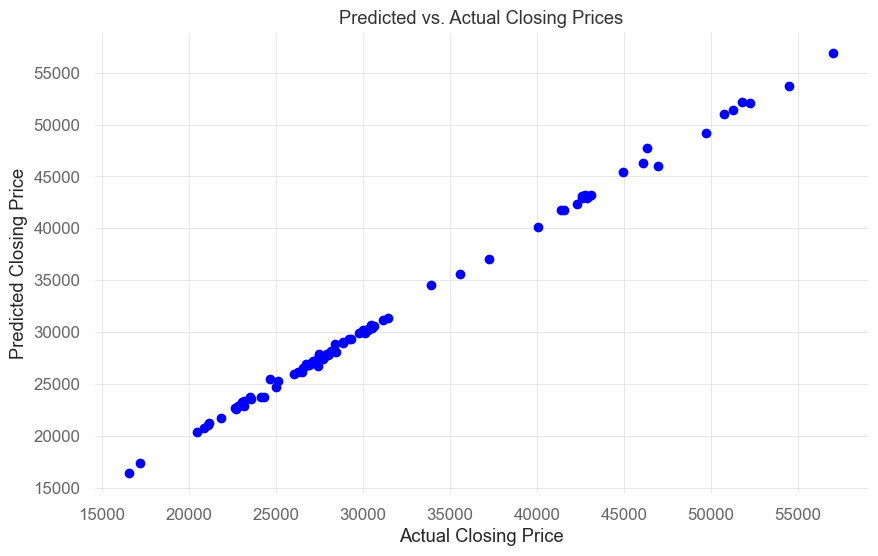

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# For simplicity, let's use Linear Regression as the model
model = LinearRegression()

# Step 4: Model Training
# Extracting features and target variable
X = daily_df_btc[['open', 'low', 'high', 'volume', 'cont_records', 'quote_volume']]
y = daily_df_btc['close']

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Plotting predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.title('Predicted vs. Actual Closing Prices')
plt.xlabel('Actual Closing Price')
plt.ylabel('Predicted Closing Price')
plt.show()

In [11]:
from statsmodels.tsa.ar_model import AutoReg

# Load the data into a pandas DataFrame
data = daily_df_btc

# Convert the 'timestamp' column to datetime format
#data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the 'timestamp' as the index
#data = data.set_index('timestamp')

# Check if the 'closePrice' column exists, if not, create it
if 'closePrice' not in data.columns:
    data['closePrice'] = data['close']

# Check for stationarity using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['closePrice'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# If the p-value is greater than 0.05, the series is likely non-stationary
# In that case, you may need to apply transformations (e.g., differencing) to make it stationary

# Split the data into train and test sets
train_data = data['closePrice'][:int(len(data)*0.8)]
test_data = data['closePrice'][int(len(data)*0.8):]

# Fit an AutoRegressive (AR) model to the training data
model = AutoReg(train_data, lags=1)
model_fit = model.fit()

# Check the AR coefficient
print(f"AR Coefficient: {model_fit.params}") #NON STARIONARY PROCESS

# If the AR coefficient is close to 1, handle non-stationarity as needed

# Make predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(data)-1)

# Evaluate the model's performance (e.g., using RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"RMSE: {rmse}")

ADF Statistic: 1.1254241257265538
p-value: 0.9954278715573308
AR Coefficient: const            94.172078
closePrice.L1     0.999491
dtype: float64
RMSE: 4170.2221612856965


In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split the data into train and test sets
train_data = data['closePrice'][:int(len(data)*0.8)]
test_data = data['closePrice'][int(len(data)*0.8):]

# Fit an ARIMA model to the training data
# The order of the ARIMA model is specified as (p, d, q)
# where p is the order of the AR term, d is the order of differencing, and q is the order of the MA term
model = ARIMA(train_data, order=(1, 1, 0))  # Example: ARIMA(1, 1, 0) model
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.forecast(steps=len(test_data))

# Convert test_data and predictions to numpy arrays
test_data_np = test_data.values
predictions_np = predictions.values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data_np, predictions_np))
print(f"RMSE: {rmse}")

RMSE: 5191.27413547511


In [15]:
daily_df_btc.head()

,timestamp,open,close,low,high,volume,cont_records,quote_volume,name,closePrice
0,2022-12-31,16520.28,16542.40,16487.74,16551.24,4973.43307,152632,8.217183e+07,BTC_SPOT,16542.40
1,2023-01-01,16541.77,16616.75,16499.01,16628.00,96925.41374,3218355,1.604794e+09,BTC_SPOT,16616.75
2,2023-01-02,16617.17,16672.87,16548.70,16799.23,121888.57191,4036118,2.034683e+09,BTC_SPOT,16672.87
3,2023-01-03,16672.78,16675.18,16605.28,16778.40,159541.53733,5097596,2.662766e+09,BTC_SPOT,16675.18
4,2023-01-04,16675.65,16850.36,16652.66,16991.87,220362.18862,6310703,3.709833e+09,BTC_SPOT,16850.36


In [14]:
daily_df_btc_perp.head()

,timestamp,open,close,low,high,volume,cont_records,quote_volume,name
0,2023-10-19,28738.5,28696.9,28579.1,28883.7,37215.516,416429,1.068229e+09,BTC_PERPETUAL
1,2023-10-20,28697.0,29653.0,28560.0,30243.0,551005.327,5390533,1.625187e+10,BTC_PERPETUAL
2,2023-10-21,29653.0,29895.4,29443.5,30374.6,258195.956,2913921,7.714009e+09,BTC_PERPETUAL
3,2023-10-22,29895.4,29981.5,29606.6,30229.7,198602.758,2402842,5.938983e+09,BTC_PERPETUAL
4,2023-10-23,29981.4,33074.0,29869.4,35981.9,987741.536,9516564,3.114312e+10,BTC_PERPETUAL


### Investor positioning analysis

### Trend-following and attention analysis

### Risk and return analysis of the cash and carry strategy

### Crypto carry and crash risk analysis
### Investigate the link between crypto carry and crash risk using option market data.

### Visualization